In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

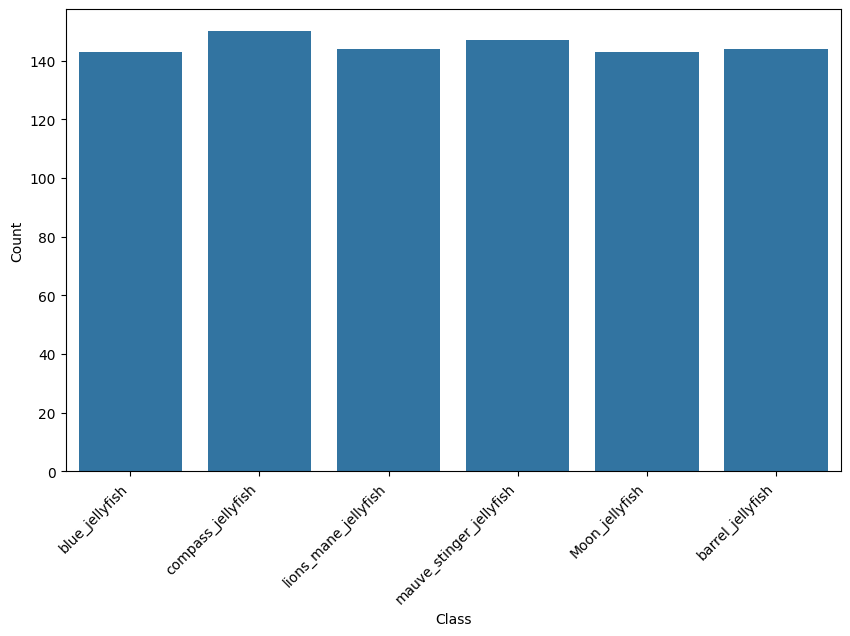

In [2]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.png', '.jpeg')):  # 이미지 파일만 필터링
                filepath = os.path.join(class_path, filename)
                img = cv2.imread(filepath)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, (224, 224))
                    img = img / 255.0
                    images.append(img)
                    labels.append(class_name)

    images = np.array(images)
    labels = label_encoder.fit_transform(labels)

    return images, labels, classes

# 데이터 로드 및 시각화
data_directory = './jellyfish_data'
images, labels, classes = load_data(data_directory)

# 클래스 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in labels])  
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# 학습 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [3]:
# 1. 데이터셋 로드 함수 (이전에 작성한 load_data 함수 사용)
data_directory = './jellyfish_data'
images, labels, classes = load_data(data_directory)

# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# 2. 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rotation_range=45,        # 최대 30도 회전
    width_shift_range=0.3,    # 가로 방향 이동
    height_shift_range=0.3,   # 세로 방향 이동
    shear_range=0.3,          # 전단 변환
    zoom_range=0.3,           # 확대/축소
    horizontal_flip=True,     # 좌우 반전
    fill_mode='nearest'       # 빈 부분을 가장 가까운 값으로 채움
)

val_datagen = ImageDataGenerator()  # 검증 데이터에는 증강 적용하지 않음

# 3. 증강된 데이터 제너레이터 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

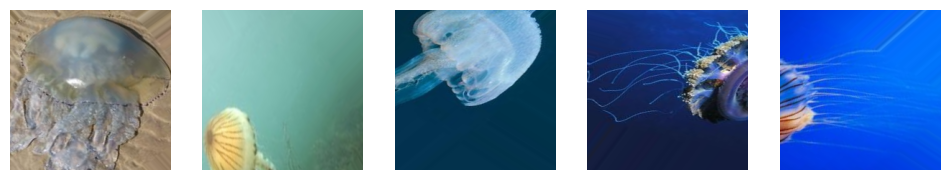

In [4]:
# 증강된 데이터 샘플 보기 함수
def plot_augmented_images(generator, n_images=5):
    # 제너레이터에서 증강된 이미지와 레이블 가져오기
    images, labels = next(generator)
    
    plt.figure(figsize=(12, 8))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# train_generator에서 샘플 이미지 보기
plot_augmented_images(train_generator)

In [5]:
# InceptionV3 모델 불러오기 및 전이 학습 설정
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 초기에는 가중치를 고정

# 분류 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('inceptionv3_jellyfish.keras', monitor='val_loss', save_best_only=True)
    ]
)

# Fine-Tuning 설정
base_model.trainable = True
for layer in base_model.layers[:100]:  # 상위 100개의 레이어는 고정
    layer.trainable = False

# Fine-Tuning 학습을 위한 재컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-Tuning 학습
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('jellyfish_inceptionv3_fine.keras', monitor='val_loss', save_best_only=True)
    ]
)

# 평가
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3168 - loss: 2.1575 - val_accuracy: 0.7486 - val_loss: 0.7263
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6186 - loss: 1.0071 - val_accuracy: 0.8000 - val_loss: 0.6490
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6905 - loss: 0.8098 - val_accuracy: 0.8000 - val_loss: 0.5791
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6955 - loss: 0.8129 - val_accuracy: 0.8457 - val_loss: 0.4878
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7788 - loss: 0.6536 - val_accuracy: 0.8571 - val_loss: 0.4494
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7876 - loss: 0.5855 - val_accuracy: 0.8171 - val_loss: 0.4740
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7796 - loss: 0.5864 - val_accuracy: 0.8971 - val_loss: 0.3943
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7592 - loss: 0.6353 - val_accuracy: 0.8800 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━

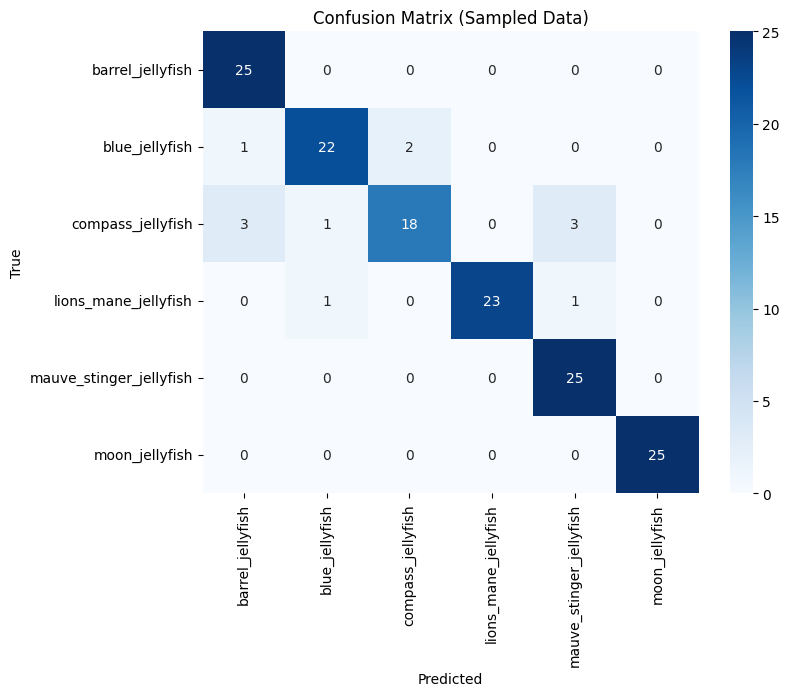

In [6]:
# 클래스 이름 제공
classes = [
    'barrel_jellyfish', 
    'blue_jellyfish', 
    'compass_jellyfish', 
    'lions_mane_jellyfish', 
    'mauve_stinger_jellyfish', 
    'moon_jellyfish'
]

samples_per_class = 25  # 클래스당 샘플 수
y_true_sampled = []
y_pred_sampled = []

# val_generator에서 데이터와 라벨 가져오기
data_images = []
data_labels = []

for img_batch, label_batch in val_generator:
    data_images.append(img_batch)
    data_labels.extend(label_batch)
    if len(data_labels) >= val_generator.n:  # 전체 샘플만큼 가져왔으면 중단
        break

data_images = np.vstack(data_images)
data_labels = np.array(data_labels)

# 클래스별 샘플링
for class_idx in range(len(classes)):  # 각 클래스 인덱스 순회
    class_data_indices = np.where(data_labels == class_idx)[0]  # 해당 클래스의 인덱스
    available_samples = len(class_data_indices)  # 해당 클래스의 데이터 수
    if available_samples == 0:
        print(f"No data available for class {classes[class_idx]}")
        continue
    actual_samples = min(samples_per_class, available_samples)  # 샘플링 크기 조정
    sampled_indices = np.random.choice(class_data_indices, size=actual_samples, replace=False)
    
    for idx in sampled_indices:
        img = data_images[idx]  # 이미지 가져오기
        y_true_sampled.append(class_idx)  # 실제 라벨 추가
        y_pred_sampled.append(np.argmax(model.predict(np.expand_dims(img, axis=0))))  # 예측값 추가

y_true_sampled = np.array(y_true_sampled)
y_pred_sampled = np.array(y_pred_sampled)

# 컨퓨전 매트릭스 생성 및 시각화
cm_sampled = confusion_matrix(y_true_sampled, y_pred_sampled)
print(classification_report(y_true_sampled, y_pred_sampled, target_names=classes))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sampled, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Sampled Data)')
plt.show()


In [7]:
from tensorflow.keras.applications import DenseNet121

# DenseNet 모델 불러오기
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 사전 학습된 가중치를 고정

# 분류 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)

# DenseNet 모델 생성
densenet_model = Model(inputs=base_model.input, outputs=output)

# 모델 컴파일
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# 모델 학습
history = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('densenet_model.keras', monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3003 - loss: 1.9673 - val_accuracy: 0.7486 - val_loss: 0.7246
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7054 - loss: 0.7928 - val_accuracy: 0.8514 - val_loss: 0.4418
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7800 - loss: 0.6007 - val_accuracy: 0.8571 - val_loss: 0.4336
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8082 - loss: 0.5070 - val_accuracy: 0.8971 - val_loss: 0.3776
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8381 - loss: 0.4143 - val_accuracy: 0.9143 - val_loss: 0.2969
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8470 - loss: 0.4051 - val_accuracy: 0.9257 - val_loss: 0.2412
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8762 - loss: 0.3582 - val_accuracy: 0.9200 - val_loss: 0.2655
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8664 - loss: 0.3471 - val_accuracy: 0.9429 - val_loss:

In [9]:
# DenseNet 평가
loss, accuracy = densenet_model.evaluate(val_generator)
print(f"DenseNet Validation Accuracy: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9778 - loss: 0.1023
DenseNet Validation Accuracy: 97.14%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/s

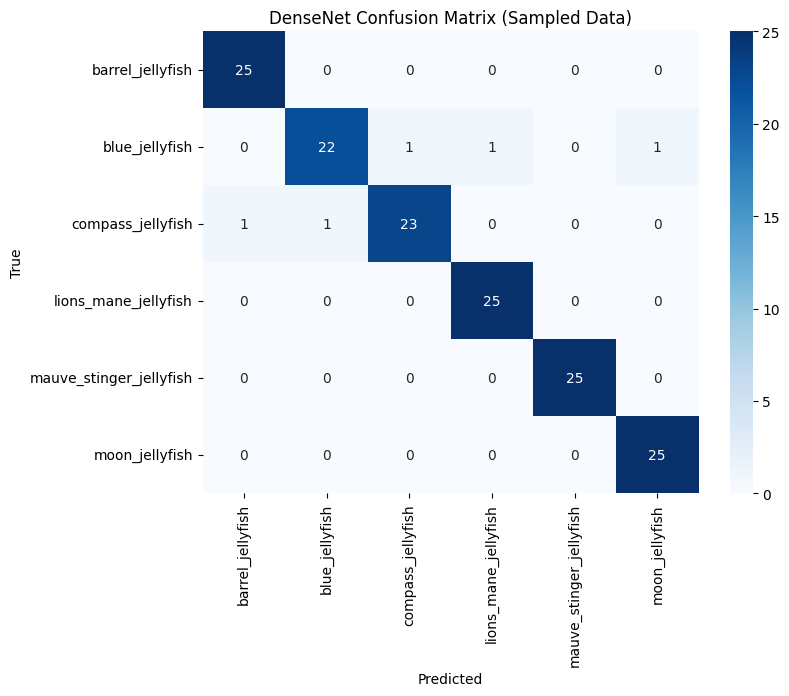

In [10]:
# 샘플링 변수 설정
samples_per_class = 25  # 클래스당 샘플 수
y_true_sampled = []
y_pred_sampled = []

# val_generator에서 데이터와 라벨 수집
data_images = []
data_labels = []

for img_batch, label_batch in val_generator:
    data_images.append(img_batch)
    data_labels.extend(label_batch)
    if len(data_labels) >= val_generator.n:  # 전체 샘플만큼 가져왔으면 중단
        break

data_images = np.vstack(data_images)
data_labels = np.array(data_labels)

# 클래스별 샘플링 및 예측
for class_idx in range(len(classes)):
    class_data_indices = np.where(data_labels == class_idx)[0]  # 해당 클래스의 인덱스
    available_samples = len(class_data_indices)  # 해당 클래스의 데이터 수
    
    if available_samples == 0:
        print(f"No data available for class {classes[class_idx]}")
        continue
    
    # 샘플링 크기 조정
    actual_samples = min(samples_per_class, available_samples)
    sampled_indices = np.random.choice(class_data_indices, size=actual_samples, replace=False)
    
    for idx in sampled_indices:
        img = data_images[idx]  # 이미지 가져오기
        y_true_sampled.append(class_idx)  # 실제 라벨 추가
        y_pred_sampled.append(np.argmax(densenet_model.predict(np.expand_dims(img, axis=0))))  # 예측값 추가

# 샘플링된 데이터로 Confusion Matrix 생성
y_true_sampled = np.array(y_true_sampled)
y_pred_sampled = np.array(y_pred_sampled)

cm_sampled = confusion_matrix(y_true_sampled, y_pred_sampled)
print(classification_report(y_true_sampled, y_pred_sampled, target_names=classes))

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm_sampled, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DenseNet Confusion Matrix (Sampled Data)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 

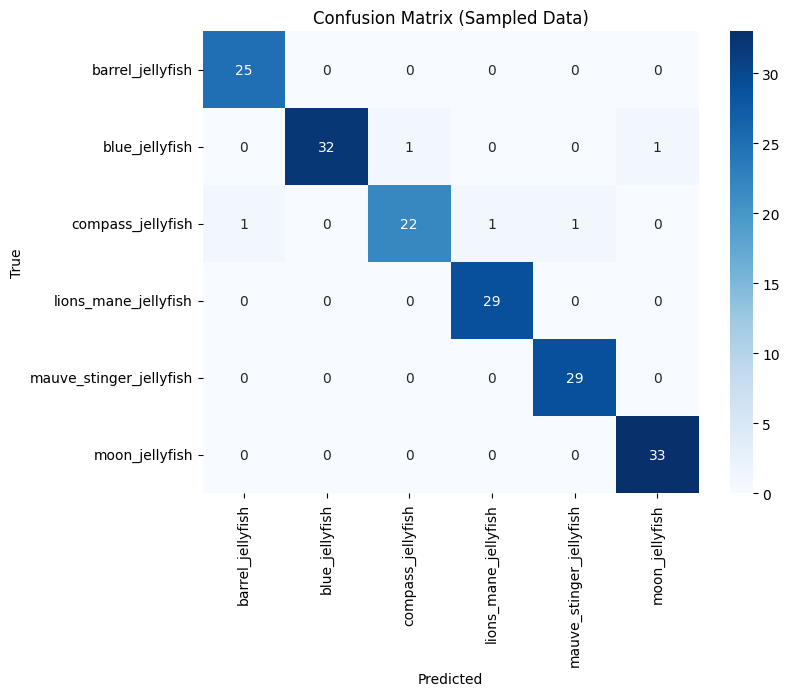

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 샘플링 설정
samples_per_class = 150  # 클래스당 샘플 개수
y_true_sampled = []
y_pred_probs_densenet = []
y_pred_probs_inception = []

# 데이터셋에서 모든 이미지와 라벨 가져오기
data_images = []
data_labels = []

for img_batch, label_batch in val_generator:
    data_images.append(img_batch)
    data_labels.extend(label_batch)
    if len(data_labels) >= val_generator.n:  # 데이터셋 끝까지 가져왔으면 종료
        break

data_images = np.vstack(data_images)
data_labels = np.array(data_labels)

# 클래스별 샘플링
for class_idx in range(len(classes)):
    class_data_indices = np.where(data_labels == class_idx)[0]  # 해당 클래스의 데이터 인덱스
    available_samples = len(class_data_indices)
    
    if available_samples == 0:
        continue
    
    # 샘플링 크기 조정
    actual_samples = min(samples_per_class, available_samples)
    sampled_indices = np.random.choice(class_data_indices, size=actual_samples, replace=False)
    
    for idx in sampled_indices:
        img = data_images[idx]  # 이미지 가져오기
        y_true_sampled.append(class_idx)  # 실제 라벨 추가
        
        # DenseNet 예측 확률
        pred_densenet = densenet_model.predict(np.expand_dims(img, axis=0))
        y_pred_probs_densenet.append(pred_densenet)
        
        # Inception 예측 확률
        pred_inception = model.predict(np.expand_dims(img, axis=0))
        y_pred_probs_inception.append(pred_inception)

# 앙상블 평가
y_pred_probs_densenet = np.vstack(y_pred_probs_densenet)
y_pred_probs_inception = np.vstack(y_pred_probs_inception)

# 앙상블: 예측 확률 평균
y_pred_probs_ensemble = (y_pred_probs_densenet + y_pred_probs_inception) / 2
y_pred_sampled = np.argmax(y_pred_probs_ensemble, axis=1)

# 평가 지표 계산
accuracy = accuracy_score(y_true_sampled, y_pred_sampled)
precision = precision_score(y_true_sampled, y_pred_sampled, average='weighted')
recall = recall_score(y_true_sampled, y_pred_sampled, average='weighted')
f1 = f1_score(y_true_sampled, y_pred_sampled, average='weighted')

# 결과 출력
print("Sampled Ensemble Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 상세한 보고서
print("\nClassification Report:")
print(classification_report(y_true_sampled, y_pred_sampled, target_names=classes))

# 컨퓨전 매트릭스 생성 및 시각화
cm_sampled = confusion_matrix(y_true_sampled, y_pred_sampled)
print(classification_report(y_true_sampled, y_pred_sampled, target_names=classes))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sampled, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Sampled Data)')
plt.show()